In [78]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import seaborn as sns

In [1]:
from scipy import stats
from sklearn.decomposition import PCA
import prince
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [2]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [93]:
import shap

In [94]:
#enabling js for shap visuals
shap.initjs()

## Data import and cleansing

In [8]:
#dataframe with histological data
histopaths = pd.read_csv("/media/artemk/Data/Udacity/DS/Cap/mussel-watch/histopaths.csv")

In [10]:
histopaths.head(3)

,abnormality,abnormality_description,bucephalus,ceroid,cestode_body,cestode_gill,cestode_mantle,chlamydia,ciliate_digestive_tract,ciliate_gut,...,station_letter,study_name,trematode_metacercariae,trematode_metacercariae_description,tumor,unidentified_gonoduct_organism,unidentified_organism,unusual_digestive_tubule,wet_weight,xenoma
0,0.0,Normal Gonad,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,Kachemak Bay Bioeffects,0.0,Uninfected,NaN,0.0,0.0,0.0,2.4,0.0
1,0.0,Normal Gonad,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,Kachemak Bay Bioeffects,0.0,Uninfected,NaN,0.0,0.0,0.0,1.3,0.0
2,0.0,Normal Gonad,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,Kachemak Bay Bioeffects,0.0,Uninfected,NaN,0.0,0.0,0.0,0.8,0.0


In [11]:
#dataframe with pollutant data
pollutants = pd.read_csv("/media/artemk/Data/Udacity/DS/Cap/mussel-watch/pollutants.csv")

/home/artemk/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,11,13,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
pollutants.head(3)

,coastal_ecological_area,collection_date,fiscal_year,general_location,latitude,longitude,matrix,method,nst_sample_id,nst_site,...,qualifier,region_name,result,scientific_name,source_file,specific_location,state_name,stratum,study_name,units
0,NaN,18AUG2015:00:00:00.000,2015.0,Chukchi Sea,NaN,NaN,Sediment,B&B SOP1006,BA2015AKC-15-005bSED,AKC_15-005,...,Below the MDL,NaN,0.104,Sediment,AlaskaArcticStudy_Organics_Sediment.csv,Peard Bay,NaN,NaN,Alaska Arctic Study,ng/dry g
1,NaN,18AUG2015:00:00:00.000,2015.0,Chukchi Sea,NaN,NaN,Sediment,B&B SOP1006,BA2015AKC-15-005bSED,AKC_15-005,...,Below the MDL,NaN,0.038,Sediment,AlaskaArcticStudy_Organics_Sediment.csv,Peard Bay,NaN,NaN,Alaska Arctic Study,ng/dry g
2,NaN,18AUG2015:00:00:00.000,2015.0,Chukchi Sea,NaN,NaN,Sediment,B&B SOP1006,BA2015AKC-15-005bSED,AKC_15-005,...,NaN,NaN,0.447,Sediment,AlaskaArcticStudy_Organics_Sediment.csv,Peard Bay,NaN,NaN,Alaska Arctic Study,ng/dry g


In [13]:
list(pollutants.columns.values)

['coastal_ecological_area',
 'collection_date',
 'fiscal_year',
 'general_location',
 'latitude',
 'longitude',
 'matrix',
 'method',
 'nst_sample_id',
 'nst_site',
 'parameter',
 'parameter_name',
 'qualifier',
 'region_name',
 'result',
 'scientific_name',
 'source_file',
 'specific_location',
 'state_name',
 'stratum',
 'study_name',
 'units']

In [14]:
pollutants.coastal_ecological_area.value_counts()

Puget Sound - Main Basin             154
Alaska South Central - Cook Inlet     64
Northern Puget Sound                  61
South Puget Sound                     45
Puget Sound - Whidney Basin           40
Name: coastal_ecological_area, dtype: int64

In [15]:
len(pollutants.nst_sample_id.unique())

8836

In [16]:
pollutants.matrix.unique()

array(['Sediment', 'Fish', 'Water', 'Fish Filet', 'Mussel', nan,
       'Fish Liver', 'Fish Muscle', 'Cockles', 'Clam', 'Not Applicable',
       'Nepheloid', 'Oyster', 'Sediment Trap', 'Coral', 'Conch',
       'Zebra Mussel Tissue', 'Flatfish', 'Shrimp', 'Starfish', 'Lobster'],
      dtype=object)

In [17]:
#find same samples across both initially imported dataframes
same_animals = list(set(histopaths.nst_sample_id.unique()) & set(pollutants.nst_sample_id.unique()))

In [18]:
#create a new dataframe of sample which are present in both initial dataframes
reduced_pollutants=pollutants[pollutants['nst_sample_id'].isin(same_animals)]

In [19]:
reduced_pollutants.groupby('parameter').count().head(3)

,coastal_ecological_area,collection_date,fiscal_year,general_location,latitude,longitude,matrix,method,nst_sample_id,nst_site,...,qualifier,region_name,result,scientific_name,source_file,specific_location,state_name,stratum,study_name,units
parameter,,,,,,,,,,,,,,,,,,,,,
"1,2,3,4-Tetrachlorobenzene",0,116,121,121,0,0,121,121,121,121,...,77,0,121,121,121,121,0,0,121,121
"1,2,4,5-Tetrachlorobenzene",0,121,126,126,0,0,126,126,126,126,...,87,0,126,126,126,126,0,0,126,126
"1,6,7-Trimethylnaphthalene",0,219,225,225,0,0,225,225,225,225,...,149,0,225,225,225,225,0,0,225,225


In [20]:
reduced_pollutants.scientific_name.unique()

array(['Mytilus edulis', 'Dreissena species', 'Chama sinuosa',
       'Crassostrea virginica', 'Isognomon alatus'], dtype=object)

In [21]:
#reducing the data to only PCB chemical group.
#Reason: otherwise dataset too big to get compehensive results
pcb_data = reduced_pollutants[reduced_pollutants['parameter'].str.contains("PCB")]

In [22]:
#Altough PCB concentration in the environment changes with time, here the span is not long enough 
pcb_data.fiscal_year.value_counts()

2007.0    429
2005.0    418
2006.0    380
2003.0    288
1995.0    270
2000.0    216
1998.0    198
1999.0    198
2004.0    198
1996.0    198
1997.0    187
2001.0    180
2002.0     90
2009.0     78
Name: fiscal_year, dtype: int64

In [23]:
pcb_data = pcb_data[np.isfinite(pcb_data['result'])]

In [24]:
pcb_data.parameter.value_counts()

PCB105            147
PCB153_132_168    147
PCB52             147
PCB101_90         147
PCB187            147
PCB28             147
PCB138_160        147
PCB128            147
PCB206            147
PCB118            147
PCB44             147
PCB8_5            147
PCB209            147
PCB66             147
PCB180            147
PCB18             147
PCB195_208        147
PCB170_190        136
PCB31              34
PCB174             34
PCB151             34
PCB49              34
PCB56_60           34
PCB183             34
PCB110_77          34
PCB70              34
PCB146             34
PCB99              34
PCB74_61           34
PCB29              34
PCB87_115          34
PCB45              34
PCB194             34
PCB201_173_157     34
PCB156_171_202     34
PCB149_123         34
PCB158             34
PCB95              34
PCB199             13
Name: parameter, dtype: int64

In [25]:
#dropping redudant column (based on domain knowledge)
pcb_data.drop(['coastal_ecological_area',
         'collection_date',
         'latitude',
         'longitude',
         'matrix',
         'method',
         'nst_site',
         'qualifier',
         'parameter_name',
         'region_name',
         'specific_location',
         'scientific_name',
         'source_file',
         'specific_location',
         'state_name',
         'stratum',
         'study_name',
         'units'], axis=1, inplace = True)

In [26]:
pcb_data.head(3)

,fiscal_year,general_location,nst_sample_id,parameter,result
12766,2009.0,Kachemak Bay,BA2009KBTBME,PCB99,0.09
12773,2009.0,Cook Inlet,BA2009CICBME,PCB99,0.00
12795,2009.0,Cook Inlet,BA2009CICBME,PCB118,0.00


In [27]:
#re-arranging the dataframe
pcb_datax = pcb_data.drop(['parameter'], axis=1).groupby(['nst_sample_id','general_location','fiscal_year'], as_index=False)['result'].sum()

In [28]:
pcb_datax.shape

(147, 4)

In [29]:
histopaths.shape

(1800, 79)

In [30]:
#reseting index on both parts of the dataset
histopaths.reset_index(drop=True, inplace=True)
pcb_datax.reset_index(drop=True, inplace=True)

In [31]:
#selecting duplicates
same_histopaths = histopaths.nst_sample_id.value_counts().index.tolist()

In [32]:
#calculating % of duplicates
len(same_histopaths)/histopaths.shape[0]

0.1411111111111111

In [33]:
#removing duplicates
histopaths = histopaths.drop_duplicates(subset='nst_sample_id')

In [34]:
#delete all columns which have NaN in more than half of entries
histopaths = histopaths.loc[:, histopaths.isnull().mean() < .5]

In [35]:
histopaths.shape

(254, 32)

In [36]:
histopaths.reset_index(drop=True, inplace=True)
pcb_datax.reset_index(drop=True, inplace=True)

In [37]:
#creating merged df of pcbs and histopaths
pcb_eco = pd.merge(pcb_datax, histopaths, on='nst_sample_id', how='inner')

In [38]:
pcb_eco.columns.values

array(['nst_sample_id', 'general_location_x', 'fiscal_year_x', 'result',
       'ceroid', 'coastal_ecological_area', 'diffuse_inflammation',
       'diffuse_necrosis', 'digestive_tubule_atrophy',
       'digestive_tubule_atrophy_description', 'fiscal_year_y',
       'focal_necrosis', 'general_location_y', 'gonadal_index',
       'gonadal_index_description', 'latitude', 'length', 'longitude',
       'nematode', 'nst_site', 'region', 'sample_letter', 'sample_number',
       'sex', 'source_file', 'species_name', 'specific_location',
       'specific_region', 'state_name', 'study_name',
       'trematode_metacercariae', 'trematode_metacercariae_description',
       'unidentified_organism', 'unusual_digestive_tubule', 'wet_weight'],
      dtype=object)

In [39]:
#dropping redundant columns - selected based on the domain knowledge
pcb_eco.drop(['general_location_x',
             'digestive_tubule_atrophy_description',
             'fiscal_year_y',
             'general_location_y', 'unidentified_organism', 'diffuse_inflammation',
             'gonadal_index_description','digestive_tubule_atrophy_description',
             'latitude',
             'longitude','source_file','specific_location', 'species_name',
             'nst_site', 'region', 'sample_letter', 'sample_number',
             'specific_region', 'state_name', 'study_name',
             'trematode_metacercariae_description'], axis=1, inplace = True)

In [40]:
pcb_eco.set_index(['nst_sample_id'], inplace=True)

In [41]:
# renaming the "result" column
pcb_eco.rename(index=str, columns={"result": "Total PCB concentration"}, inplace = True)

In [42]:
"""
Deleting columns with only 1 value
"""
def column_calue_detector(dataframe):
    list_colummns = []
    columns = list(dataframe.columns.values)
    for column in columns:
        if len(dataframe[column].value_counts()) == 1:
            list_colummns.append([column])
    
    flat_list = [item for sublist in list_colummns for item in sublist]
    dataframe.drop(flat_list, axis=1, inplace=True)
    
    return dataframe

In [43]:
pcb_eco1 = column_calue_detector(pcb_eco)

In [44]:
#filling Nans with the most frequent value
pcb_eco1 = pcb_eco1.fillna(pcb_eco1.mode().iloc[0])

In [45]:
pcb_eco1['sex'].count()

147

In [46]:
pcb_eco1.groupby('sex')['Total PCB concentration'].nunique()

sex
Female     63
Male       61
Unknown    23
Name: Total PCB concentration, dtype: int64

In [47]:
#replacing "Unknown" entries in the sex column
pcb_eco1['sex'] = pcb_eco1['sex'].replace({'Unknown': 'Male'})

In [48]:
pcb_eco1.dtypes

fiscal_year_x               float64
Total PCB concentration     float64
ceroid                      float64
coastal_ecological_area      object
digestive_tubule_atrophy    float64
gonadal_index                object
length                      float64
sex                          object
unusual_digestive_tubule    float64
wet_weight                  float64
dtype: object

/home/artemk/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


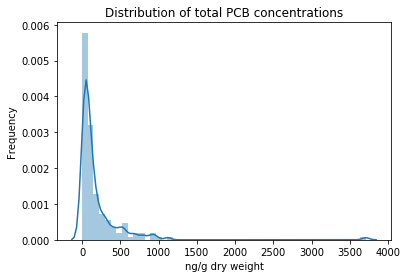

In [49]:
#PCB concentration distributionx
sns.distplot(pcb_eco1['Total PCB concentration'])
plt.title('Distribution of total PCB concentrations')
plt.ylabel('Frequency')
plt.xlabel('ng/g dry weight')
plt.show()

In [50]:
"""
Label-encoding non-float columns
"""
def encoder(dataframe):
    dataframe = dataframe.copy()
    le = preprocessing.LabelEncoder()
    for column in dataframe.columns:
        if dataframe[column].dtype != np.float64:
            dataframe[column] = le.fit_transform(dataframe[column])
    
    return dataframe

In [51]:
pcb_eco2 = encoder(pcb_eco1)

In [52]:
#now the dataframe is ready for further work
pcb_eco2.head(3)

,fiscal_year_x,Total PCB concentration,ceroid,coastal_ecological_area,digestive_tubule_atrophy,gonadal_index,length,sex,unusual_digestive_tubule,wet_weight
nst_sample_id,,,,,,,,,,
BA2009CICBME,2009.0,0.00,0.0,0,1.0,8,3.9,1,0.0,2.4
BA2009KBTBME,2009.0,4.14,0.0,1,2.0,9,5.0,1,0.0,2.7
MW1995LEABDS,1995.0,181.19,0.0,2,2.0,3,2.0,1,0.0,0.4


/home/artemk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


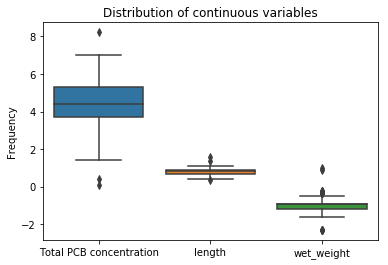

In [53]:
eco_con = pcb_eco2[['Total PCB concentration', "length", "wet_weight"]]
ax = sns.boxplot(data=np.log(eco_con))
plt.title('Distribution of continuous variables')
plt.ylabel('Frequency')
plt.show()

/home/artemk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


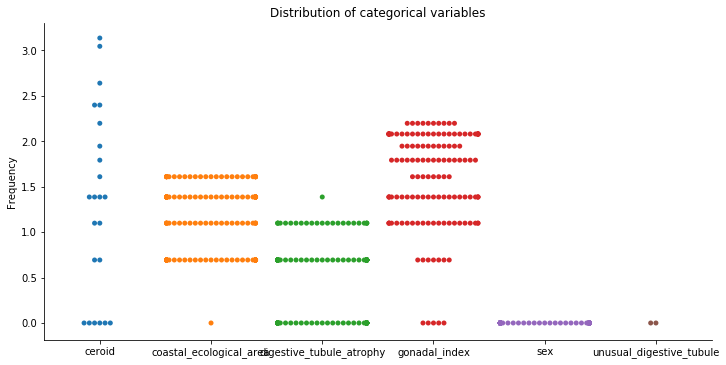

In [54]:
eco_con = pcb_eco2.drop(['Total PCB concentration', "length", "wet_weight", 'fiscal_year_x'], axis=1)
ax = sns.catplot(data=np.log(eco_con), kind="swarm", aspect=2)
plt.title('Distribution of categorical variables')
plt.ylabel('Frequency')
plt.show()

## Modelling

In [55]:
X = pcb_eco2.drop(['Total PCB concentration'], axis=1)

In [56]:
y = pcb_eco2['Total PCB concentration']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### PCA and FAMD

In [58]:
pca = PCA(n_components=2).fit(pcb_eco2)
pca_2d = pca.transform(pcb_eco2)

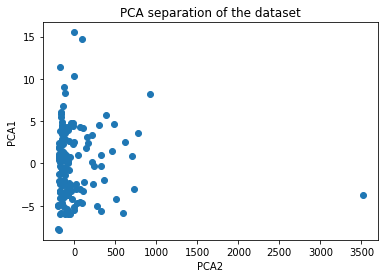

In [59]:
plt.scatter(pca_2d[:,0],pca_2d[:,1])
plt.title('PCA separation of the dataset')
plt.ylabel('PCA1')
plt.xlabel('PCA2')
plt.show()

In [60]:
famd = prince.FAMD(
     n_components=15,
     n_iter=1000,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=0)

In [61]:
#the not-encoded dataframe is used because the fit method has already an encoding step built in
famd = famd.fit(pcb_eco1)

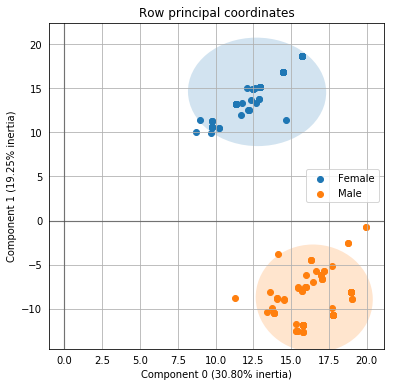

In [62]:
ax = famd.plot_row_coordinates(
     pcb_eco1,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     #labels=pcb_eco1.index,
     color_labels=[t for t in pcb_eco1['sex']],
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)
plt.show()

### Random Forest

In [56]:
#performing gridsearch for best RandomForest parameters
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
            'max_depth': range(3,20),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
print(best_params)

{'max_depth': 5, 'n_estimators': 10}


/home/artemk/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [63]:
#initializig RandomForest
start = time.time()
regressor = RandomForestRegressor(n_estimators=10, max_depth=5,random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)
print('Random Forest RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
end = time.time()
print(end - start)

Random Forest RMSE: 246.37031205683562
0.01656365394592285


In [298]:
#just some extra metrics for randm forest
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  

In [53]:
#constructing dataframe with feature importance from RandomForest
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

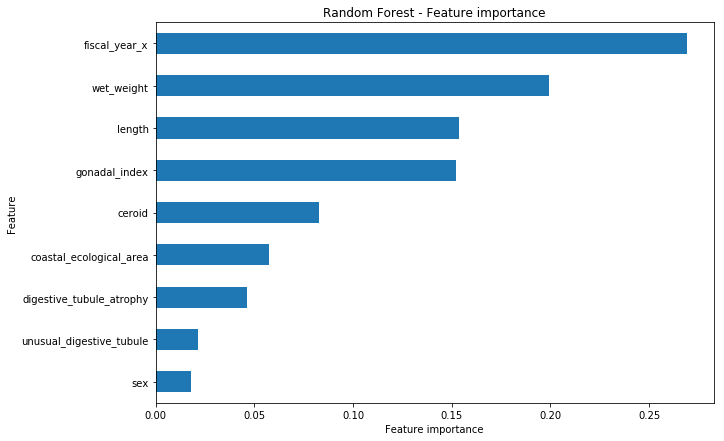

In [317]:
ax = feature_importances.plot.barh(figsize=(10, 7))
ax.grid(False)
ax.get_legend().remove()
plt.title('Random Forest - Feature importance')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

### CatBoost

In [66]:
categorical = ['coastal_ecological_area',
               'digestive_tubule_atrophy',
               'gonadal_index',
               'sex',
               'unusual_digestive_tubule'
              ]

In [67]:
"""
Returns sorted array of indexes of categorical columns
"""
def column_index(df, query_cols):
    cols = df.columns.values
    idx = np.argsort(cols)
    sorted_columns_idx = idx[np.searchsorted(cols, query_cols, sorter=idx)]
    return sorted_columns_idx

In [68]:
categorical_features_indices = column_index(X, categorical)

In [71]:
#performing gridsearch for best CatBoost parameters
gsc = GridSearchCV(
    estimator=CatBoostRegressor(),
    param_grid={
            'depth': range(4,10),
            'learning_rate': (0.01, 0.025,  0.05, 0.1),
            'bagging_temperature' : (0.1, 0.25, 0.5) 
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
print(best_params)

/home/artemk/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/artemk/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/artemk/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/artemk/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/extern

0:	learn: 448.6900628	total: 3.36ms	remaining: 3.35s
1:	learn: 447.6543081	total: 5.54ms	remaining: 2.76s
2:	learn: 446.7850090	total: 6.96ms	remaining: 2.31s
3:	learn: 445.7091779	total: 9.58ms	remaining: 2.38s
4:	learn: 444.8373348	total: 11.3ms	remaining: 2.25s
5:	learn: 443.8970954	total: 12.8ms	remaining: 2.11s
6:	learn: 443.0462974	total: 15ms	remaining: 2.12s
7:	learn: 442.2218940	total: 17.1ms	remaining: 2.12s
8:	learn: 441.3378608	total: 19.5ms	remaining: 2.14s
9:	learn: 440.3206381	total: 21.8ms	remaining: 2.15s
10:	learn: 439.6065577	total: 24.5ms	remaining: 2.2s
11:	learn: 438.8260204	total: 27.2ms	remaining: 2.24s
12:	learn: 438.1358139	total: 28.6ms	remaining: 2.17s
13:	learn: 437.1300251	total: 30.3ms	remaining: 2.13s
14:	learn: 436.4354792	total: 32.9ms	remaining: 2.16s
15:	learn: 435.6376603	total: 35.9ms	remaining: 2.21s
16:	learn: 434.9882910	total: 37.7ms	remaining: 2.18s
17:	learn: 434.3331149	total: 39.1ms	remaining: 2.13s
18:	learn: 433.5710468	total: 40.6ms	rema

191:	learn: 369.2420520	total: 178ms	remaining: 749ms
192:	learn: 368.8595212	total: 180ms	remaining: 751ms
193:	learn: 368.7097782	total: 181ms	remaining: 751ms
194:	learn: 368.6525426	total: 182ms	remaining: 751ms
195:	learn: 368.2659891	total: 183ms	remaining: 752ms
196:	learn: 367.4453664	total: 184ms	remaining: 751ms
197:	learn: 367.2811069	total: 187ms	remaining: 759ms
198:	learn: 367.1675413	total: 189ms	remaining: 759ms
199:	learn: 367.0488466	total: 190ms	remaining: 758ms
200:	learn: 366.8269213	total: 191ms	remaining: 759ms
201:	learn: 366.6629977	total: 192ms	remaining: 758ms
202:	learn: 366.5628749	total: 193ms	remaining: 757ms
203:	learn: 365.7854204	total: 194ms	remaining: 756ms
204:	learn: 365.6754820	total: 195ms	remaining: 757ms
205:	learn: 365.6278791	total: 196ms	remaining: 756ms
206:	learn: 364.8919642	total: 197ms	remaining: 756ms
207:	learn: 364.1504967	total: 198ms	remaining: 756ms
208:	learn: 364.0697105	total: 200ms	remaining: 756ms
209:	learn: 364.0147902	tota

639:	learn: 247.8103063	total: 520ms	remaining: 293ms
640:	learn: 247.7714388	total: 521ms	remaining: 292ms
641:	learn: 247.4637036	total: 522ms	remaining: 291ms
642:	learn: 247.3700477	total: 523ms	remaining: 290ms
643:	learn: 246.9055082	total: 524ms	remaining: 290ms
644:	learn: 246.7156029	total: 525ms	remaining: 289ms
645:	learn: 246.4438228	total: 526ms	remaining: 288ms
646:	learn: 245.9967096	total: 526ms	remaining: 287ms
647:	learn: 245.9566278	total: 527ms	remaining: 286ms
648:	learn: 245.7837324	total: 529ms	remaining: 286ms
649:	learn: 245.3498028	total: 530ms	remaining: 285ms
650:	learn: 244.9975068	total: 531ms	remaining: 285ms
651:	learn: 244.8873392	total: 532ms	remaining: 284ms
652:	learn: 244.7284893	total: 533ms	remaining: 283ms
653:	learn: 244.5429083	total: 534ms	remaining: 283ms
654:	learn: 244.3876869	total: 535ms	remaining: 282ms
655:	learn: 244.2080101	total: 536ms	remaining: 281ms
656:	learn: 244.1116242	total: 537ms	remaining: 280ms
657:	learn: 244.0540319	tota

811:	learn: 209.6258091	total: 685ms	remaining: 159ms
812:	learn: 209.6011868	total: 687ms	remaining: 158ms
813:	learn: 209.5067422	total: 689ms	remaining: 157ms
814:	learn: 209.1380012	total: 693ms	remaining: 157ms
815:	learn: 208.9094892	total: 694ms	remaining: 157ms
816:	learn: 208.8724944	total: 695ms	remaining: 156ms
817:	learn: 208.7105788	total: 696ms	remaining: 155ms
818:	learn: 208.3445660	total: 696ms	remaining: 154ms
819:	learn: 208.2452011	total: 697ms	remaining: 153ms
820:	learn: 208.0182599	total: 698ms	remaining: 152ms
821:	learn: 207.9203317	total: 699ms	remaining: 151ms
822:	learn: 207.8088662	total: 700ms	remaining: 150ms
823:	learn: 207.7032438	total: 701ms	remaining: 150ms
824:	learn: 207.5383361	total: 702ms	remaining: 149ms
825:	learn: 207.3904356	total: 703ms	remaining: 148ms
826:	learn: 207.0267093	total: 704ms	remaining: 147ms
827:	learn: 206.8962581	total: 705ms	remaining: 146ms
828:	learn: 206.8064332	total: 706ms	remaining: 146ms
829:	learn: 206.6612307	tota

{'bagging_temperature': 0.5, 'depth': 4, 'learning_rate': 0.01}


In [72]:
#initializing CatBoost
start = time.time()
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=4,
                             eval_metric='RMSE',
                             random_seed = 0,
                             bagging_temperature = 0.5,
                             od_type='Iter',
                             metric_period = 30,
                             od_wait=100)
model.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
                 cat_features=categorical_features_indices,
use_best_model=True)

end = time.time()
print(end - start)

0:	learn: 448.7984541	test: 313.3807220	best: 313.3807220 (0)	total: 852us	remaining: 596ms
30:	learn: 426.0110443	test: 284.5178361	best: 284.5178361 (30)	total: 34.9ms	remaining: 753ms
60:	learn: 409.3784755	test: 265.5408890	best: 265.5408890 (60)	total: 84.5ms	remaining: 886ms
90:	learn: 397.2646674	test: 253.4346597	best: 253.4346597 (90)	total: 114ms	remaining: 762ms
120:	learn: 388.1377230	test: 246.6062600	best: 246.6062600 (120)	total: 142ms	remaining: 681ms
150:	learn: 379.2959950	test: 242.2668298	best: 242.2668298 (150)	total: 167ms	remaining: 606ms
180:	learn: 370.6226545	test: 238.2040821	best: 238.2040821 (180)	total: 199ms	remaining: 570ms
210:	learn: 363.7113301	test: 235.1170158	best: 235.0598284 (209)	total: 240ms	remaining: 556ms
240:	learn: 354.8470638	test: 233.8595164	best: 233.8595164 (240)	total: 280ms	remaining: 533ms
270:	learn: 346.2402939	test: 232.1790897	best: 232.1790897 (270)	total: 307ms	remaining: 486ms
300:	learn: 336.9584324	test: 230.7503985	best: 

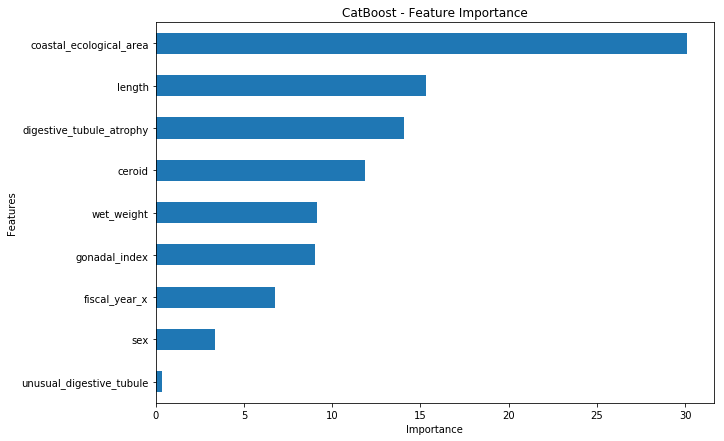

In [88]:
#plotting feature importance by CatBoost
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.grid(False)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### LightGBM

In [61]:
feature_names = X.columns.tolist()

In [62]:
#performing data split for Lightgbm
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = categorical, free_raw_data=False)
lgvalid = lgb.Dataset(X_test, y_test,
                feature_name=feature_names,
                categorical_feature = categorical, free_raw_data=False)

In [65]:
#performing gridsearch for best LightGBM parameters
gsc = GridSearchCV(
    estimator=lgb.LGBMRegressor(),
    param_grid={
            'num_leaves': range(25,32),
            'max_depth': (25, 30, 35),
            'learning_rate': (0.01, 0.05, 0.1)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
print(best_params)

{'learning_rate': 0.01, 'max_depth': 25, 'num_leaves': 25}


/home/artemk/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [66]:
#initializing Lightgbm
start = time.time()
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 25,
    'max_depth': 25,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.9,
    'verbosity' : -1
}
lgb_clf = lgb.train(
    params,
    lgtrain,
    #num_iterations=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=500,
    verbose_eval=500
)
print("RMSE of the test set:", np.sqrt(metrics.mean_squared_error(y_test, lgb_clf.predict(X_test))))

end = time.time()
print(end - start)

Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 390.837	valid's rmse: 164.46
RMSE of the test set: 164.45952396213866
0.09077024459838867


/home/artemk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/artemk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


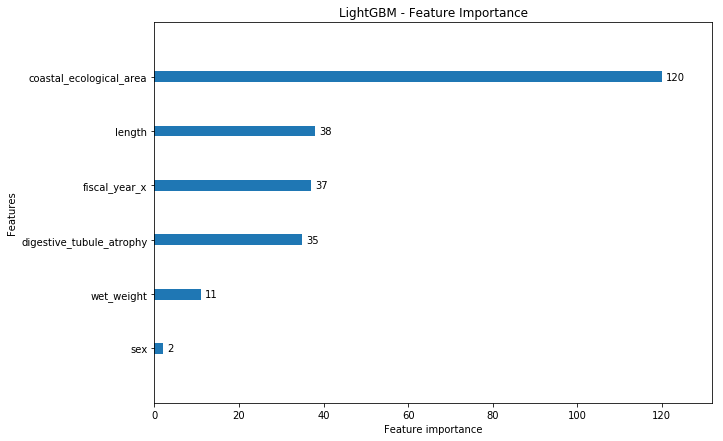

In [309]:
#plotting feature importance by Lightgbm
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax, grid=False)
plt.title("LightGBM - Feature Importance")
plt.show()

### Comparing methods

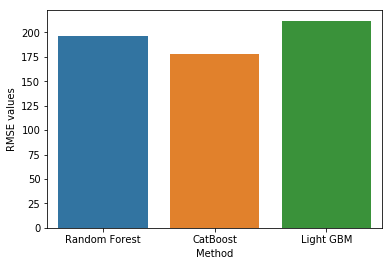

In [310]:
#plot RMSE
RMSE = pd.DataFrame({'Method':['Random Forest', 'CatBoost', 'Light GBM'], 'RMSE values':[196, 178, 212]})
sns.barplot(x='Method', y='RMSE values', data=RMSE)
plt.show()

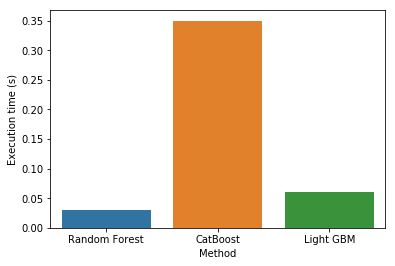

In [311]:
#plot time
Extime = pd.DataFrame({'Method':['Random Forest', 'CatBoost', 'Light GBM'], 'Execution time (s)':[0.03, 0.35, 0.06]})
sns.barplot(x='Method', y='Execution time (s)', data=Extime)
plt.show()

### MWW analysis

In [312]:
#constructing numpy arrays from dataframe for statistical analysis - Mann–Whitney U (MWW) test
#for animal sex
sex1 = np.array(pcb_eco2.loc[pcb_eco2['sex'] == 0, 'Total PCB concentration'])
sex2 = np.array(pcb_eco2.loc[pcb_eco2['sex'] == 1, 'Total PCB concentration'])
#and for sampling locations
loc1 = np.array(pcb_eco2.loc[pcb_eco2['coastal_ecological_area'] == 0, 'Total PCB concentration'])
loc2 = np.array(pcb_eco2.loc[pcb_eco2['coastal_ecological_area'] == 1, 'Total PCB concentration'])
loc3 = np.array(pcb_eco2.loc[pcb_eco2['coastal_ecological_area'] == 2, 'Total PCB concentration'])
loc4 = np.array(pcb_eco2.loc[pcb_eco2['coastal_ecological_area'] == 3, 'Total PCB concentration'])
loc5 = np.array(pcb_eco2.loc[pcb_eco2['coastal_ecological_area'] == 4, 'Total PCB concentration'])
loc6 = np.array(pcb_eco2.loc[pcb_eco2['coastal_ecological_area'] == 5, 'Total PCB concentration'])
loc_list = [loc1, loc2, loc3, loc4, loc5, loc6]

In [313]:
#performing MWW test for difference in sex
print(stats.mannwhitneyu(sex1,sex2))

MannwhitneyuResult(statistic=2544.0, pvalue=0.3455740259459129)


In [314]:
#checking amount of samples taken in each location
for loc in loc_list:
    print(len(loc))

1
1
50
24
43
28


In [315]:
#printing p-values for most logical combination of locations
print(stats.mannwhitneyu(loc3,loc4))
print(stats.mannwhitneyu(loc3,loc5))
print(stats.mannwhitneyu(loc3,loc6))
print(stats.mannwhitneyu(loc4,loc6))
print(stats.mannwhitneyu(loc5,loc6))

MannwhitneyuResult(statistic=267.0, pvalue=6.167287720198703e-05)
MannwhitneyuResult(statistic=1016.0, pvalue=0.32607454750885234)
MannwhitneyuResult(statistic=323.0, pvalue=4.395716094720066e-05)
MannwhitneyuResult(statistic=266.0, pvalue=0.10102856056734227)
MannwhitneyuResult(statistic=289.0, pvalue=0.00011812372238111148)


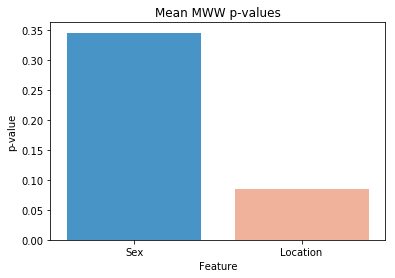

In [316]:
MWW_score = pd.DataFrame({'Feature':['Sex', 'Location'], 'p-value':[0.345, 0.085]})
sns.barplot(x='Feature', y='p-value', data=MWW_score, palette = ["#3498db",'#ffab8d'])
plt.title('Mean MWW p-values')
plt.show()

### SHAP

In [95]:
# re-setting CatBoost as the best performing model to use it with shap
model = CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=9,
                             eval_metric='RMSE',
                             random_seed = 0,
                             bagging_temperature = 0.5,
                             od_type='Iter',
                             metric_period = 30,
                             od_wait=100)

In [96]:
model.fit(X, y, verbose=False, plot=False)

In [97]:
#initializing shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

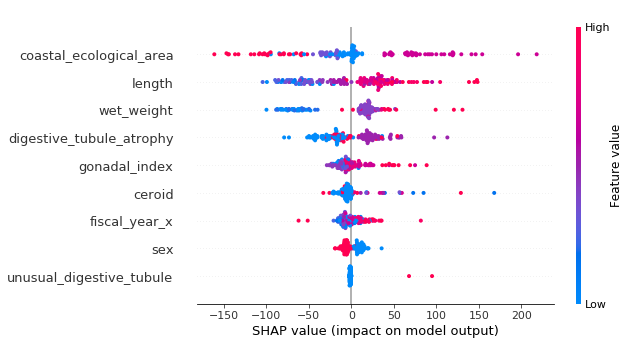

In [90]:
#SHAP effects of all the features
shap.summary_plot(shap_values, X)

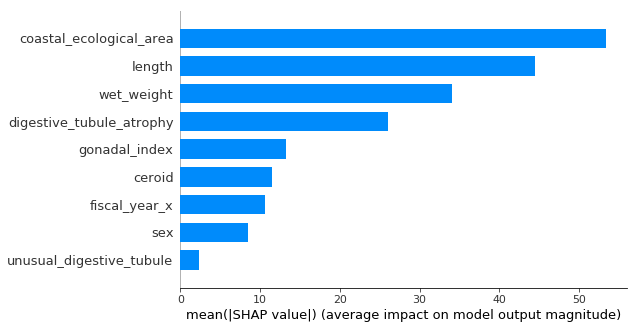

In [91]:
#SHAP effects of all the features in a bar plot
shap.summary_plot(shap_values, X, plot_type="bar")

In [92]:
#the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

## EXTRA 1: PBDE

### The idea behind this attemeped project was to try predict concentration of PBDE congener 209, which is more difficult to measure directly than other congeners. However, this does not seem possible with the current dataset

In [9]:
pbdes=pollutants[pollutants['parameter'].str.contains("BDE",na=False)]

In [10]:
pbdes.parameter.value_counts()

BDE 25 [2,3',4-TriBDE]                           365
BDE 85 [2,2',3,4,4'-PentaBDE]                    365
BDE 181 [2,2',3,4,4',5,6-HeptaBDE]               365
BDE 15 [4,4'-DiBDE]                              365
BDE 37 [3,4,4'-TriBDE]                           365
BDE 183 [2,2',3,4,4',5',6-HeptaBDE]              365
BDE 66 [2,3',4,4'-TetraBDE]                      365
BDE 33 [2',3,4-TriBDE]                           365
BDE 7 [2,4-DiBDE]                                365
BDE 17 [2,2',4-TriBDE]                           365
BDE 153 [2,2',4,4',5,5'-HexaBDE]                 365
BDE 10 [2,6-DiBDE]                               365
BDE 30 [2,4,6-TriBDE]                            365
BDE 28 [2,4,4'-TriBDE]                           365
BDE 13 [3,4'-DiBDE]                              365
BDE 138 [2,2',3,4,4',5'-HexaBDE]                 365
BDE 166 [2,3,4,4',5,6-HexaBDE]                   365
BDE 32 [2,4',6-TriBDE]                           365
BDE 155 [2,2',4,4',6,6'-HexaBDE]              

In [11]:
pbde_data = pbdes[~pbdes.parameter.str.contains("BDE 71|BDE 49|BDE 4")]

In [12]:
#getting a list of all samples with measured PBDE209
list_of_samples_with_bde209=pbde_data.loc[pbde_data['parameter'].str.contains("BDE 209"), 'nst_sample_id']
list_of_samples_with_bde209 = np.array(list_of_samples_with_bde209)
list_of_samples_with_bde209 = list(set(list_of_samples_with_bde209))

In [13]:
#selecting only samples with measured PBDE209 
model_dataset_pbde = pbde_data[pbde_data['nst_sample_id'].isin(list_of_samples_with_bde209)]

In [14]:
model_dataset_pbde.fiscal_year.value_counts()

2007.0    4655
2009.0    1225
2012.0     539
2010.0     147
Name: fiscal_year, dtype: int64

In [15]:
model_dataset_pbde_short = model_dataset_pbde.drop(['coastal_ecological_area',
                         'fiscal_year',
         'collection_date',
         'general_location',
         'latitude',
         'longitude',
         'matrix',
         'method',
         'nst_site',
         'qualifier',
         'parameter_name',
         'region_name',
         'specific_location',
         'scientific_name',
         'source_file',
         'specific_location',
         'state_name',
         'stratum',
         'study_name',
         'units'], axis=1)

In [16]:
#re-arranging df
model_dataset_pbde1 = model_dataset_pbde_short.pivot(index='nst_sample_id', columns='parameter')['result']

In [17]:
#dropping columns with all values =0
model_dataset_pbde1 = model_dataset_pbde1.loc[:, (model_dataset_pbde1 != 0.0).any(axis=0)]

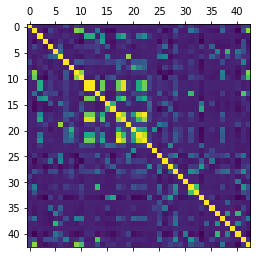

In [18]:
plt.matshow(model_dataset_pbde1.corr())
plt.show()

In [24]:
X = model_dataset_pbde1.drop(columns=["BDE 209 [2,2',3,3',4,4',5,5',6,6'-DecaBDE]"])
y = model_dataset_pbde1["BDE 209 [2,2',3,3',4,4',5,5',6,6'-DecaBDE]"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [26]:
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)

In [27]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

In [28]:
y_pred = lm.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

62.50649325199599

In [34]:
from sklearn.model_selection import train_test_split

In [140]:
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,20),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    print(best_params)

{'max_depth': 8, 'n_estimators': 100}


/home/artemk/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=8,random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)  

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 13.16056458338894
Mean Squared Error: 3948.41711938634
Root Mean Squared Error: 62.83643146603998


In [32]:
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,eval_set=(X_test, y_test),plot=True)

0:	learn: 6.9759097	test: 62.7169888	best: 62.7169888 (0)	total: 47.3ms	remaining: 2.32s
1:	learn: 6.7666515	test: 62.7067863	best: 62.7067863 (1)	total: 48.8ms	remaining: 1.17s
2:	learn: 6.6482818	test: 62.6938878	best: 62.6938878 (2)	total: 50.3ms	remaining: 788ms
3:	learn: 6.5166157	test: 62.6813946	best: 62.6813946 (3)	total: 51.1ms	remaining: 588ms
4:	learn: 6.3489294	test: 62.6766756	best: 62.6766756 (4)	total: 52ms	remaining: 468ms
5:	learn: 6.2275459	test: 62.6797419	best: 62.6766756 (4)	total: 52.8ms	remaining: 387ms
6:	learn: 6.0991058	test: 62.6841716	best: 62.6766756 (4)	total: 53.6ms	remaining: 329ms
7:	learn: 5.9758544	test: 62.6757025	best: 62.6757025 (7)	total: 54.8ms	remaining: 288ms
8:	learn: 5.9001759	test: 62.6802746	best: 62.6757025 (7)	total: 55.7ms	remaining: 254ms
9:	learn: 5.8475353	test: 62.6867179	best: 62.6757025 (7)	total: 56.6ms	remaining: 226ms
10:	learn: 5.7317437	test: 62.6778116	best: 62.6757025 (7)	total: 57.4ms	remaining: 203ms
11:	learn: 5.6859530	t

## Extra 2. Analysis of DDT group time series

### The aim of this attempted project was to compare dataseries of DDT/DDE and DDT/DDD concentrations. However, the current dataset has a too short span to accomplish this task in a meaningfu way

In [241]:
ddts = {"4,4'-DDT", "2,4'-DDT", "4,4'-DDD", "2,4'-DDD", "2,4'-DDE", "4,4'-DDE"}

In [242]:
ddt_data = reduced_pollutants[reduced_pollutants['parameter'].str.contains("DD")]

In [47]:
ddt_data.parameter.value_counts()

4,4'-DDD    146
4,4'-DDT    146
4,4'-DDE    146
2,4'-DDE    146
2,4'-DDT    146
2,4'-DDD    146
DDMU          2
Name: parameter, dtype: int64

In [48]:
ddt_data = ddt_data[ddt_data.parameter != 'DDMU']

In [49]:
ddt_data.scientific_name.value_counts()

Dreissena species    864
Mytilus edulis        12
Name: scientific_name, dtype: int64

In [50]:
ddt_data = ddt_data[ddt_data.scientific_name != 'Mytilus edulis']

In [51]:
ddt_data.units.value_counts()
ddt_data.fiscal_year.value_counts()

2003.0    96
1995.0    90
2000.0    72
2005.0    66
2007.0    66
1999.0    66
1997.0    66
2004.0    66
1996.0    66
1998.0    60
2001.0    60
2006.0    60
2002.0    30
Name: fiscal_year, dtype: int64

In [52]:
ddt_data.general_location.value_counts()

Lake Erie        294
Lake Michigan    180
Lake Ontario     168
Lake Huron        72
Saginaw Bay       72
Traverse Bay      36
Green Bay         36
Niagara River      6
Name: general_location, dtype: int64

In [54]:
ddt_data.groupby('general_location')['fiscal_year'].nunique()

general_location
Green Bay        6
Lake Erie        8
Lake Huron       7
Lake Michigan    6
Lake Ontario     7
Niagara River    1
Saginaw Bay      7
Traverse Bay     6
Name: fiscal_year, dtype: int64

In [55]:
ddt_data.groupby(['general_location','fiscal_year'])['result'].nunique()

general_location  fiscal_year
Green Bay         1996.0          6
                  1998.0          4
                  2000.0          6
                  2002.0          6
                  2004.0          6
                  2006.0          6
Lake Erie         1995.0         31
                  1996.0          6
                  1997.0         39
                  1999.0         21
                  2001.0         34
                  2003.0         42
                  2005.0         37
                  2007.0         37
Lake Huron        1995.0          2
                  1996.0         12
                  1998.0          8
                  2000.0          8
                  2002.0         12
                  2004.0         12
                  2006.0          4
Lake Michigan     1996.0         24
                  1998.0         18
                  2000.0         32
                  2003.0         30
                  2004.0         30
                  2006.0         3

In [56]:
ddt_data = ddt_data[ddt_data.general_location != 'Niagara River']

In [57]:
ddt_data.drop(['coastal_ecological_area',
         'collection_date',
         'latitude',
         'longitude',
         'matrix',
         'method',
         'nst_site',
         'qualifier',
         'parameter_name',
         'region_name',
         'specific_location',
         'scientific_name',
         'source_file',
         'specific_location',
         'state_name',
         'stratum',
         'study_name',
         'units'], axis=1, inplace = True)

In [58]:
ddt_data.set_index(['nst_sample_id', 'general_location','fiscal_year'], inplace=True)

In [60]:
ppDDT = pd.DataFrame(ddt_data.loc[ddt_data['parameter'] == "4,4'-DDT", 'result'])
opDDT = pd.DataFrame(ddt_data.loc[ddt_data['parameter'] == "2,4'-DDT", 'result'])
DDT = ppDDT['result'] + opDDT['result']

In [61]:
ppDDE = pd.DataFrame(ddt_data.loc[ddt_data['parameter'] == "4,4'-DDE", 'result'])
opDDE = pd.DataFrame(ddt_data.loc[ddt_data['parameter'] == "2,4'-DDE", 'result'])
DDE = ppDDE['result'] + opDDE['result']

In [62]:
ppDDD = pd.DataFrame(ddt_data.loc[ddt_data['parameter'] == "4,4'-DDD", 'result'])
opDDD = pd.DataFrame(ddt_data.loc[ddt_data['parameter'] == "2,4'-DDD", 'result'])
DDD = ppDDD['result'] + opDDD['result']

In [63]:
DDTs = pd.concat([DDT, DDE, DDD], axis=1)

In [64]:
DDTs.columns = ['DDT', 'DDE', 'DDD']

In [65]:
DDTs = DDTs.reset_index(drop=False)

In [66]:
DDTs.drop(['nst_sample_id'], axis=1,inplace = True)

In [67]:
DDTs.set_index(['general_location','fiscal_year'], inplace =True)

In [68]:
DDTs.head(3)

DDT     DDE     DDD
general_location fiscal_year                        
Lake Erie        1995.0       11.337  19.432  23.384
                 1995.0        0.720   3.100   2.845
                 1995.0        1.937   9.139   8.412

In [69]:
DDTs['DDT/DDE ratio'] = DDTs['DDT']/DDTs['DDE']

In [70]:
DDTs['DDT/DDD ratio'] = DDTs['DDT']/DDTs['DDD']

In [71]:
ddt_place_time = DDTs.drop(['DDT', 'DDE', 'DDD'], axis=1, inplace=True)
ddt_place_time = DDTs.groupby(['general_location','fiscal_year']).mean()

In [75]:
years = list(range(1996,2009,1))

In [77]:
for year in years:
    if year not 

[1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]

In [72]:
ddt_place_time

DDT/DDE ratio  DDT/DDD ratio
general_location fiscal_year                              
Green Bay        1996.0            0.089588       0.232704
                 1998.0            0.000000       0.000000
                 2000.0            0.346113       0.391283
                 2002.0            0.306103       0.342306
                 2004.0            0.083654       0.208791
                 2006.0            0.110599       0.452830
Lake Erie        1995.0            0.232585       0.232089
                 1996.0            0.314709       0.355670
                 1997.0            0.512635       0.427910
                 1999.0            0.114311       0.049744
                 2001.0            0.689847       0.403983
                 2003.0            0.731899       0.362837
                 2005.0            0.659651       0.624934
                 2007.0            1.218991       0.718640
Lake Huron       1995.0            0.000000            NaN
                 1996.0            0.469419       1.027475
                 1998.0            0.744725            inf
                 2000.0            0.285806       0.222166
                 2002.0            2.386914       3.696898
                 2004.0            0.319961       0.353945
                 2006.0            0.263158       0.431034
Lake Michigan    1996.0            0.236542       0.604519
                 1998.0            0.210549       0.369313
                 2000.0            0.253449       0.449847
                 2003.0            0.772873       1.809170
                 2004.0            0.354488       0.520158
                 2006.0            0.496856       0.441627
Lake Ontario     1995.0            0.241434       0.529863
                 1997.0            0.452684       0.685296
                 1999.0            0.288554       0.668194
                 2001.0            1.042943       1.047444
                 2003.0            1.108461       0.615297
                 2005.0            1.105679       0.873704
                 2007.0            0.849071       1.518050
Saginaw Bay      1995.0            0.021006       0.017703
                 1996.0            0.095337       0.109172
                 1998.0            0.027003       0.023202
                 2000.0            0.197849       0.129342
                 2002.0            2.898790       5.781443
                 2004.0            0.186731       0.148924
                 2006.0            0.068802       0.048739
Traverse Bay     1996.0            0.151631       0.367442
                 1998.0            0.000000            NaN
                 2000.0            0.000000       0.000000
                 2002.0            2.676768       2.322863
                 2004.0            0.637595       0.579231
                 2006.0            0.000000            NaN

In [80]:
ddt_place_time=ddt_place_time[(ddt_place_time != 0).all(1)]
ddt_place_time=ddt_place_time.replace([np.inf, -np.inf], np.nan)
ddt_place_time.dropna(how='any', inplace=True)

In [81]:
ddt_place_time

DDT/DDE ratio  DDT/DDD ratio
general_location fiscal_year                              
Green Bay        1996.0            0.089588       0.232704
                 2000.0            0.346113       0.391283
                 2002.0            0.306103       0.342306
                 2004.0            0.083654       0.208791
                 2006.0            0.110599       0.452830
Lake Erie        1995.0            0.232585       0.232089
                 1996.0            0.314709       0.355670
                 1997.0            0.512635       0.427910
                 1999.0            0.114311       0.049744
                 2001.0            0.689847       0.403983
                 2003.0            0.731899       0.362837
                 2005.0            0.659651       0.624934
                 2007.0            1.218991       0.718640
Lake Huron       1996.0            0.469419       1.027475
                 2000.0            0.285806       0.222166
                 2002.0            2.386914       3.696898
                 2004.0            0.319961       0.353945
                 2006.0            0.263158       0.431034
Lake Michigan    1996.0            0.236542       0.604519
                 1998.0            0.210549       0.369313
                 2000.0            0.253449       0.449847
                 2003.0            0.772873       1.809170
                 2004.0            0.354488       0.520158
                 2006.0            0.496856       0.441627
Lake Ontario     1995.0            0.241434       0.529863
                 1997.0            0.452684       0.685296
                 1999.0            0.288554       0.668194
                 2001.0            1.042943       1.047444
                 2003.0            1.108461       0.615297
                 2005.0            1.105679       0.873704
                 2007.0            0.849071       1.518050
Saginaw Bay      1995.0            0.021006       0.017703
                 1996.0            0.095337       0.109172
                 1998.0            0.027003       0.023202
                 2000.0            0.197849       0.129342
                 2002.0            2.898790       5.781443
                 2004.0            0.186731       0.148924
                 2006.0            0.068802       0.048739
Traverse Bay     1996.0            0.151631       0.367442
                 2002.0            2.676768       2.322863
                 2004.0            0.637595       0.579231